In [137]:
import json
import pandas as pd

f = open('validation_set.json',)
validation_df = json.load(f)
print("validation set size: {}".format(len(validation_df)))
#print(validation_df[0])

flavor_df = json.load(open('flavor_DB.json',))
flavorlist=[]
for i in range(len(flavor_df)):
    flavorlist.append(flavor_df[i]['entity_alias_readable']) 
    
print("# of unique flavors: {}".format(len(flavorlist)))

validation set size: 100
# of unique flavors: 934


In [225]:
from thefuzz import fuzz
from thefuzz import process
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns

##for a single ingredient match against all flavors. find match with best ratio. output that flavor.
from Levenshtein import distance as lev
from collections import defaultdict
import time

class stringmatch(object):
    def __init__(self, flavor_df):
        self.flavorlist=[]
        for i in range(len(flavor_df)):
            self.flavorlist.append(flavor_df[i]['entity_alias_readable']) 
    def shortenstring(self,text,i):
        return (','.join(text.split(',')[:i]))
    def flavormatch0(self,ingredient, xlimit=1):
        #print("input ingredient: {}".format(ingredient))
        match = process.extract(ingredient, self.flavorlist, limit=xlimit)
        #print("best matches: {}".format(match))
        return match
    def flavormatch1(self,ingredient, xlimit=1):
        ingredient_s=shortenstring(ingredient,1)
        match = process.extract(ingredient_s, self.flavorlist, limit=xlimit)
        return match
    def flavormatch2(self,ingredient, xlimit=1):
        ingredient_s=shortenstring(ingredient,2)
        match = process.extract(ingredient_s, self.flavorlist, limit=xlimit)
        return match
    def flavormatch3(self,ingredient, xlimit=1):
        ingredient_s=shortenstring(ingredient,3)
        match = process.extract(ingredient_s, self.flavorlist, limit=xlimit)
        return match
    def flavormatch4(self,ingredient, xlimit=1):
        match = process.extract(ingredient, self.flavorlist, limit=xlimit, scorer=fuzz.token_sort_ratio)
        return match
    def flavormatch5(self,ingredient, xlimit=1):
        match = process.extract(ingredient, self.flavorlist, limit=xlimit, scorer=fuzz.token_set_ratio)
        return match
    def levmatch(self,ingredient,matches,num=2):
        scores=defaultdict(int)
        for i in range(len(matches)):

            scores[matches[i]]=lev(ingredient,matches[i])
        max_keys = sorted(scores, key=scores.get)[:3]
        print("input ingredient: {}".format(ingredient))
        print("best matches: {}".format(max_keys))
    def to_list(self,validation_df):  #input is validation_df
        val_set=[]
        val_labels=[]
        for i in validation_df:
            for j in i['ingredients']:
                val_set.append(j['text'])
            for j in i['ingredients_flavormatch']:
                val_labels.append(j['text'])
        return val_set,val_labels

    def cm_accuracy(self,pred, labels): #compare 2 lists
        assert len(pred)==len(labels)
        total=len(pred)
        matches=0
        misses=0
        for i in range(total):
            if pred[i]==labels[i]:
                matches+=1
            else:
                misses+=1
        accuracy=matches/total
        return accuracy

    def display_confusion_matrix(self,pred,labels):
        assert len(pred)==len(labels)
        total=len(pred)
        return confusion_matrix(pred, labels)

In [196]:
z=stringmatch(flavor_df)
val_set,val_labels=z.to_list(validation_df)

def accuracy(val_set, alg, zlimit):
    compare = pd.DataFrame(
        {'input': val_set,
        'actual labels': val_labels})
    compare['index']= compare.index
    val_predictions=[]
    sa=str(alg)
    for i in val_set:
        if alg==0:
            val_predictions.append(z.flavormatch0(i,zlimit)) 
        elif alg==1:
            val_predictions.append(z.flavormatch1(i,zlimit)) 
        elif alg==2:
            val_predictions.append(z.flavormatch2(i,zlimit)) 
        elif alg==3:
            val_predictions.append(z.flavormatch3(i,zlimit)) 
        elif alg==4:
            val_predictions.append(z.flavormatch4(i,zlimit)) 
        elif alg==5:
            val_predictions.append(z.flavormatch5(i,zlimit)) 

    for i in range(zlimit):
        compare[sa+str(i)]=compare["index"].apply(lambda x: val_predictions[x][i][0])
    compare[sa+"_match?"]=compare.drop("actual labels", 1).isin(compare["actual labels"]).any(1)
    compare[sa+"_match?"]=compare[sa+"_match?"].astype(int)
    acc=compare[sa+"_match?"].sum()/len(compare[sa+"_match?"])
    print(compare.head())
    return acc

#acc0=[accuracy(val_set,0,1),accuracy(val_set,0,2),accuracy(val_set,0,3),accuracy(val_set,0,4)]
#acc1=[accuracy(val_set,1,1),accuracy(val_set,1,2),accuracy(val_set,1,3),accuracy(val_set,1,4)]
#acc2=[accuracy(val_set,2,1),accuracy(val_set,2,2),accuracy(val_set,2,3),accuracy(val_set,2,4)]
#acc3=[accuracy(val_set,3,1),accuracy(val_set,3,2),accuracy(val_set,3,3),accuracy(val_set,3,4)]
#acc4=[]
#acc4.append(accuracy(val_set,4,1),accuracy(val_set,4,2),accuracy(val_set,4,3),accuracy(val_set,4,4))
#acc5=[]
#acc5.append(accuracy(val_set,5,1),accuracy(val_set,5,2),accuracy(val_set,5,3),accuracy(val_set,5,4))

In [198]:
acc4=[accuracy(val_set,4,1),accuracy(val_set,4,2),accuracy(val_set,4,3),accuracy(val_set,4,4)]
acc5=[accuracy(val_set,5,1),accuracy(val_set,5,2),accuracy(val_set,5,3),accuracy(val_set,5,4)]

                                         input    actual labels  index  \
0  wheat flour, white, all-purpose, unenriched            Flour      0   
1                leavening agents, baking soda  Leavening agent      1   
2                         butter, without salt           Butter      2   
3                        cream, sour, cultured            Cream      3   
4                      corn, sweet, white, raw             Corn      4   

                40  4_match?  
0    White Currant         0  
1  Leavening agent         1  
2    Peanut Butter         0  
3        Ice cream         0  
4    White Currant         0  
                                         input    actual labels  index  \
0  wheat flour, white, all-purpose, unenriched            Flour      0   
1                leavening agents, baking soda  Leavening agent      1   
2                         butter, without salt           Butter      2   
3                        cream, sour, cultured            Cream      3   

Text(0.5, 0, 'k nearest')

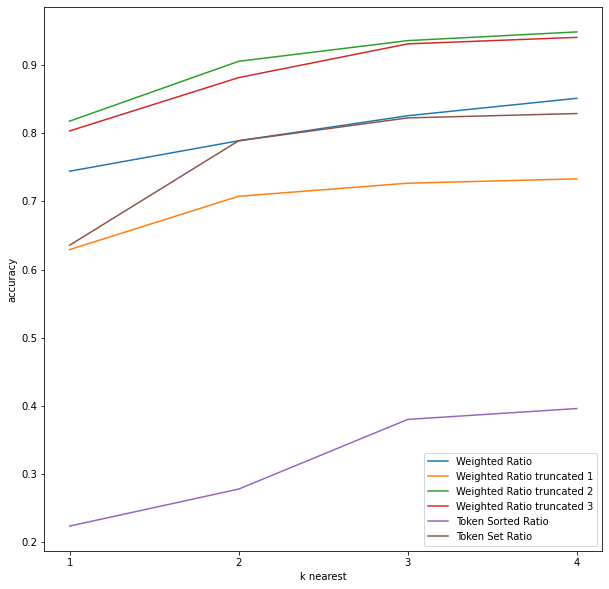

In [218]:
import matplotlib.pyplot as plt
x=[1,2,3,4]
labels=['Weighted Ratio','Weighted Ratio truncated 1','Weighted Ratio truncated 2','Weighted Ratio truncated 3','Token Sorted Ratio','Token Set Ratio']
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(x,acc0)
plt.plot(x,acc1)
plt.plot(x,acc2)
plt.plot(x,acc3)
plt.plot(x,acc4)
plt.plot(x,acc5)
plt.xticks(x)
plt.legend(labels)
plt.ylabel('accuracy')
plt.xlabel('k nearest')

In [235]:
##this cell can take a few minutes
##Use algorithm 0 - fuzzy wuzzy defaults
val_predictions=[]
for i in val_set:
    val_predictions.append(z.flavormatch2(i)[0][0])

In [232]:
#finds all unique labels from val_predictions and val_labels joied
unique=list(set(val_labels))+list(set(val_predictions)-set(val_labels))
cm=confusion_matrix(val_predictions, val_labels,labels=unique)

In [233]:
len(unique)

139

<AxesSubplot:>

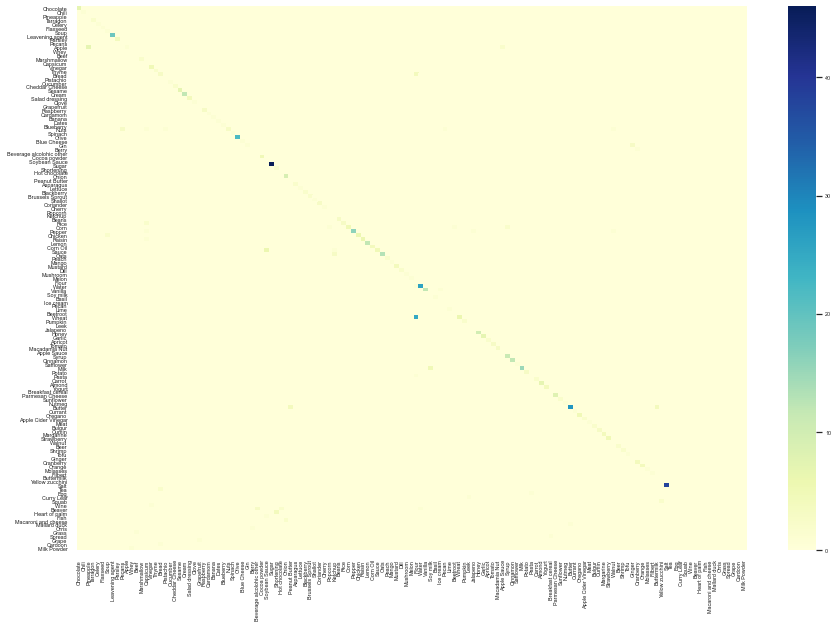

In [234]:
sns.set(rc = {'figure.figsize':(15,10)})
sns.set(font_scale=.5)
sns.heatmap(cm, cmap="YlGnBu",xticklabels=unique, yticklabels=unique)

<AxesSubplot:>

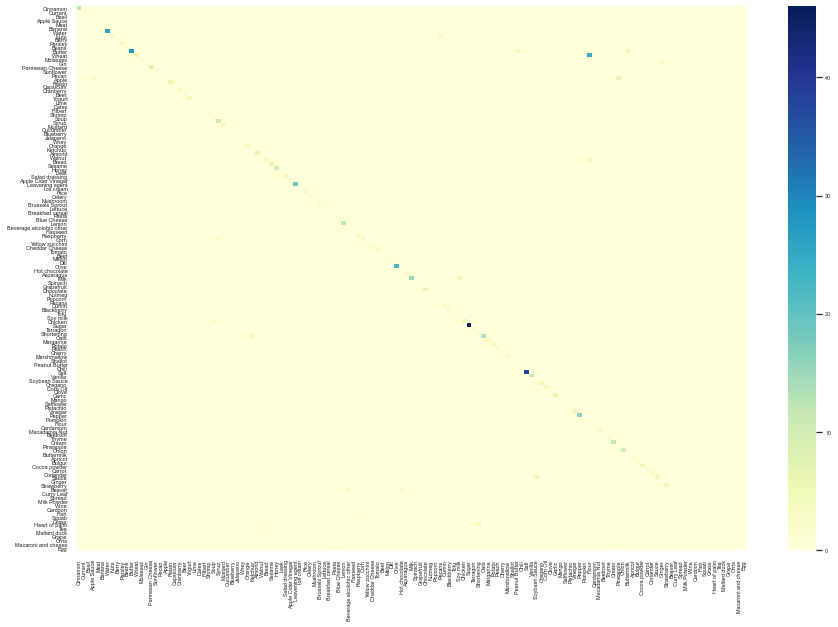

In [210]:
sns.set(rc = {'figure.figsize':(15,10)})
sns.set(font_scale=.5)
sns.heatmap(cm, cmap="YlGnBu",xticklabels=unique, yticklabels=unique)

In [197]:
unique=compare[compare['p3']>0]['actual labels']
len(list(unique))

398

In [136]:
total=len(val_set)
for i in range(total):
    print(val_predictions[i],val_labels[i])

Wheat Flour
Leavening agent Leavening agent
Butter Butter
Cream Cream
Corn Corn
Rice Rice
Soft drink Bread
Nuts Almond
Sweet Grass Raisin
Cinnamon Cinnamon
Syrup Syrup
Olive Olive
Vanilla Vanilla
Milk Milk
Olive Olive
Molasses Molasses
Bread Bread
Wheat Flour
Yellow zucchini Corn
Salt Salt
Leavening agent Leavening agent
Cocoa Cocoa powder
Strawberry Jam Strawberry
Frankfurter Sausage Sugar
Lemon Lemon
Butter Butter
Sauce Sauce
Allspice Capsicum
Pepper Pepper
Salt Salt
Garlic Garlic
Onion Onion
Pepper Pepper
Pepper Walnut
Nuts Capsicum
Frankfurter Sausage Sugar
Sweet Potato Potato
Water Water
Wheat Flour
Leavening agent Leavening agent
Salt Salt
Milk Milk
Frankfurter Sausage Sugar
Water Water
Butter Butter
Cheese Cheddar Cheese
Onion Onion
Mustard Mustard
Banana Banana
Wheat Wheat
Cocoa Cocoa powder
Brown bear Sugar
Salt Salt
Leavening agent Leavening agent
Leavening agent Leavening agent
Vanilla Soy milk
Oil-seed Camellia Apple Sauce
Salt Margarine
Butter Peanut Butter
Red Sage Sugar
